In [2]:
import pandas as pd

# Load data
df = pd.read_csv('product_analysis.csv')

# Initial inspection
print(df.head())

                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [4]:
# Check for missing values
print("Missing values:", df.isnull().sum())

Missing values: Review       1
Sentiment    0
dtype: int64


In [5]:
# Drop rows with missing values if any
df.dropna(inplace=True)

In [ ]:
print("Missing values:", df.isnull().sum())

Missing values: Review       0
Sentiment    0
dtype: int64


In [6]:
# Sentiment Mapping (1,2 -> Negative; 3 -> Neutral; 4,5 -> Positive)
df['Sentiment'] = df['Sentiment'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

In [7]:
# Verify distribution
print(df['Sentiment'].value_counts())

Sentiment
0    10000
2     9999
1     5000
Name: count, dtype: int64


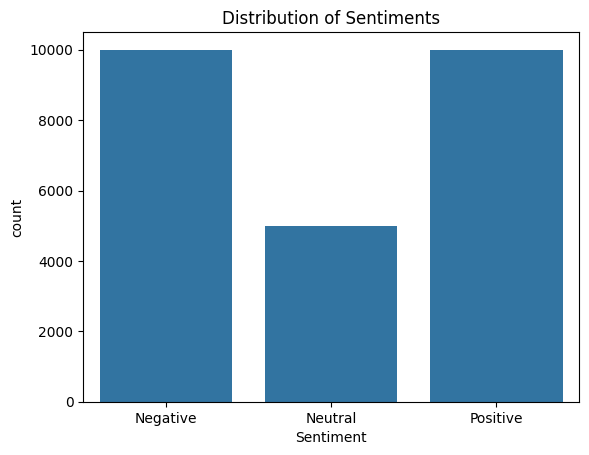

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()


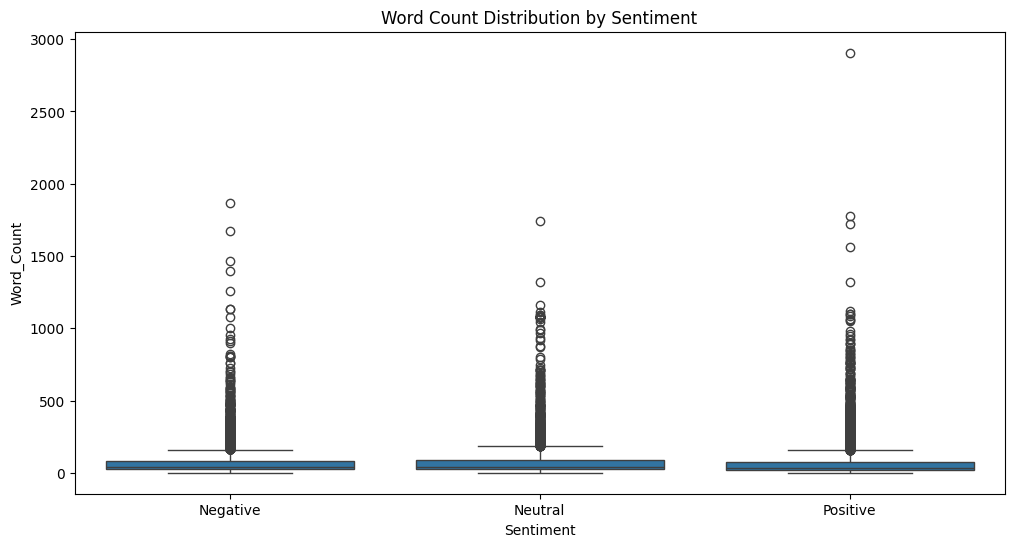

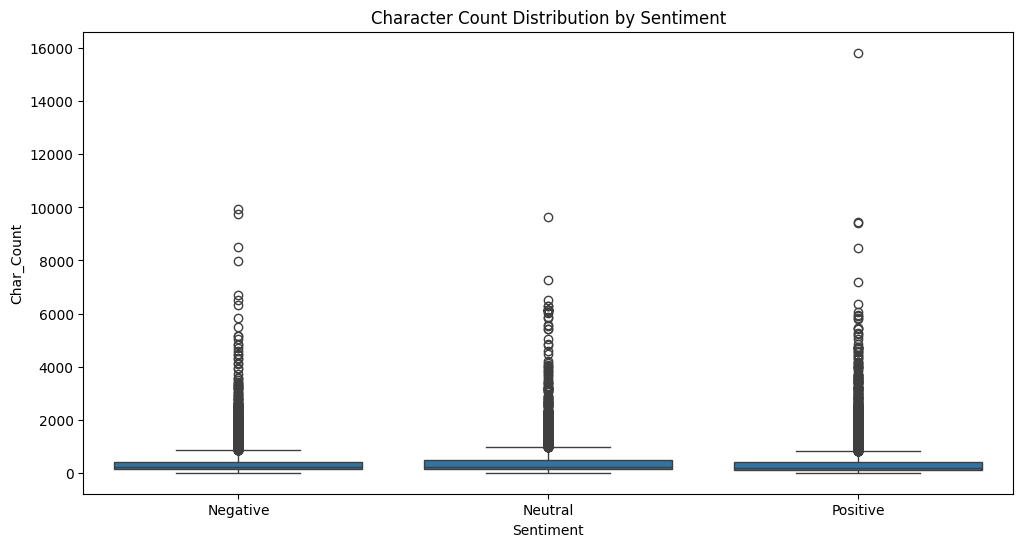

In [9]:
# Calculate review lengths
df['Word_Count'] = df['Review'].apply(lambda x: len(str(x).split()))
df['Char_Count'] = df['Review'].apply(lambda x: len(str(x)))

# Visualize review lengths by sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sentiment', y='Word_Count', data=df)
plt.title('Word Count Distribution by Sentiment')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Sentiment', y='Char_Count', data=df)
plt.title('Character Count Distribution by Sentiment')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()


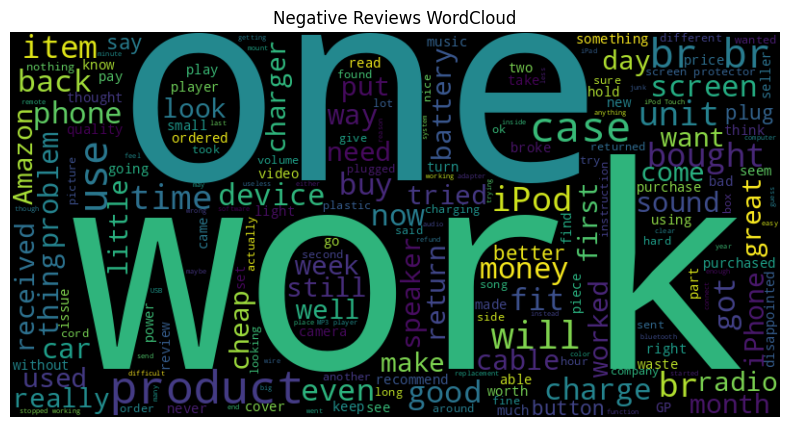

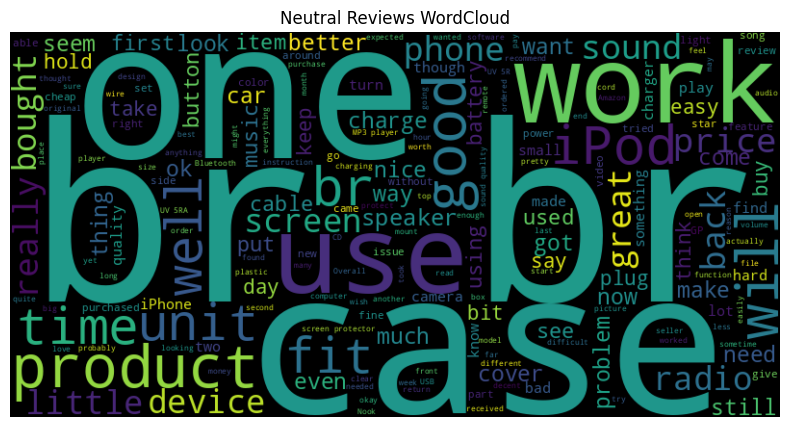

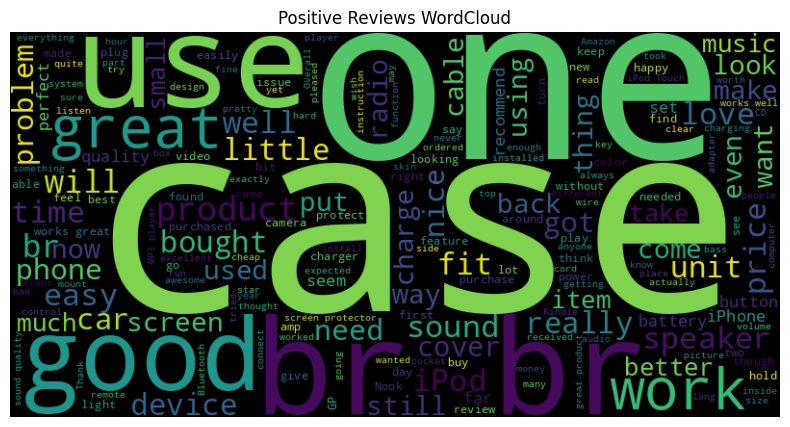

In [10]:
from wordcloud import WordCloud

# Create word clouds for each sentiment
def generate_wordcloud(sentiment, label):
    text = ' '.join(df['Review'][df['Sentiment'] == sentiment].astype(str))
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{label} Reviews WordCloud')
    plt.axis('off')
    plt.show()

generate_wordcloud(0, 'Negative')
generate_wordcloud(1, 'Neutral')
generate_wordcloud(2, 'Positive')


In [11]:
print("Average Word Count by Sentiment:")
print(df.groupby('Sentiment')['Word_Count'].mean())

print("Average Character Count by Sentiment:")
print(df.groupby('Sentiment')['Char_Count'].mean())


Average Word Count by Sentiment:
Sentiment
0    66.706600
1    77.624600
2    67.382338
Name: Word_Count, dtype: float64
Average Character Count by Sentiment:
Sentiment
0    356.241100
1    414.548400
2    360.144814
Name: Char_Count, dtype: float64


In [12]:
!pip install nltk


In [13]:
# Preprocessing Cleaning, Lemmatization, Stopword Removal
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())  # Lemmatization
    return text

df['Cleaned_Review'] = df['Review'].apply(preprocess_text)
print(df.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                              Review  Sentiment  Word_Count  \
0  Fast shipping but this product is very cheaply...          0          42   
1  This case takes so long to ship and it's not e...          0          15   
2  Good for not droids. Not good for iPhones. You...          0          29   
3  The cable was not compatible between my macboo...          0          20   
4  The case is nice but did not have a glow light...          0          20   

   Char_Count                                     Cleaned_Review  
0         227  fast shipping product cheaply made brought gra...  
1          71            case take long ship even worth dont buy  
2         146  good droids good iphones cannot use feature wa...  
3         122  cable compatible macbook iphone also connector...  
4         112  case nice glow light im disappointed product d...  


In [14]:
# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle


In [16]:
# Define the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2500)

# Fit and transform the cleaned reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Review'])  # Assume 'Cleaned_Review' column is preprocessed

# Convert the sparse matrix to an array (if needed)
tfidf_array = tfidf_matrix.toarray()

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


TF-IDF Matrix Shape: (24999, 2500)


In [17]:
# Target variable (Sentiment) and features (TF-IDF representation)
X = tfidf_matrix
y = df['Sentiment']  # Sentiment column already mapped to [0: negative, 1: neutral, 2: positive]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Train Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")


Train Data Shape: (18749, 2500)
Test Data Shape: (6250, 2500)


In [20]:
# Create a dictionary to save the pipeline components
pipeline = {
    'tfidf_vectorizer': tfidf_vectorizer,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

# Save the pipeline as a .pkl file
with open('tfidf_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("TF-IDF pipeline saved successfully!")


TF-IDF pipeline saved successfully!


In [22]:
# Load the saved pipeline
with open('tfidf_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

tfidf_vectorizer = loaded_pipeline['tfidf_vectorizer']
X_train = loaded_pipeline['X_train']
X_test = loaded_pipeline['X_test']
y_train = loaded_pipeline['y_train']
y_test = loaded_pipeline['y_test']


print(f"Loaded Train Data Shape: {X_train.shape}")
print(f"Loaded Test Data Shape: {X_test.shape}")


Loaded Train Data Shape: (18749, 2500)
Loaded Test Data Shape: (6250, 2500)


Accuracy: 0.6952

Classification Report:

              precision    recall  f1-score   support

    Negative       0.71      0.82      0.76      2501
     Neutral       0.43      0.21      0.28      1217
    Positive       0.74      0.80      0.77      2532

    accuracy                           0.70      6250
   macro avg       0.63      0.61      0.61      6250
weighted avg       0.67      0.70      0.67      6250

          Negative  Neutral  Positive
Negative      2057      182       262
Neutral        517      260       440
Positive       338      166      2028


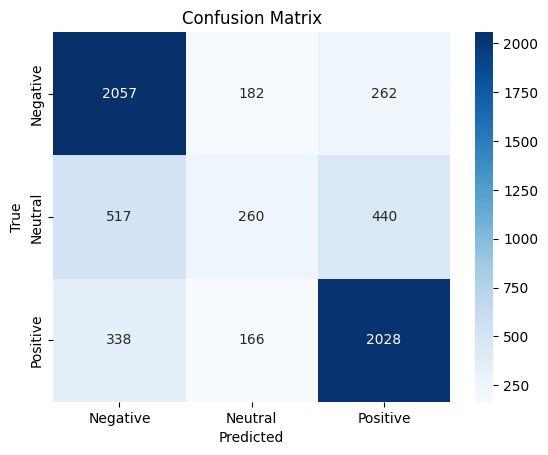

Logistic Regression model saved successfully!


In [23]:
# Model Training
# Import necessary libraries
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 1: Train Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Step 2: Model Evaluation
y_pred = logreg_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Negative", "Neutral", "Positive"],
                     columns=["Negative", "Neutral", "Positive"])
print(cm_df)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Step 3: Save the Trained Model
with open('logreg_model.pkl', 'wb') as model_file:
    pickle.dump(logreg_model, model_file)

print("Logistic Regression model saved successfully!")


